In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc,rcParams
from numba import jit, types
from matplotlib import colors
from IPython import display
import pandas as pd
import time
rc('font', weight='bold')
sns.set_palette(['steelblue', 'orange', 'indianred', 'seagreen'])

## AGM with Two Strains

### AGM Setup Functions

In [ ]:
#Set grid, represented as 1d numpy array
@jit(nopython=True)
def set_grid(num_sus, num_s1, num_s2, num_agents):
    if (num_sus+num_s1+num_s2) <= num_agents and num_agents**.5 % 1 == 0:
        frac_sus = num_sus/num_agents
        frac_s1 = num_s1/num_agents
        frac_s2 = num_s2/num_agents
        frac_empty = 1 - frac_sus - frac_s1 - frac_s2
        grid = np.random.choice(np.array([0,1,2,3]), num_agents, [frac_empty,frac_sus,frac_s1,frac_s2])
        return grid
    else:
        print('Error. Number of agents exceeds grid size.')

# function to find all neighbors of an agent
@jit(nopython=True)
def get_neighbors(index, grid):
    sideLength = int(np.sqrt(len(grid)))
    above = (index - sideLength) % len(grid)
    right = np.floor(index / sideLength)*sideLength + (index % sideLength + 1) % sideLength
    bottom = (index + sideLength) % len(grid)
    left = np.floor(index / sideLength)*sideLength + (index % sideLength - 1) % sideLength
        
    top_right = (right - sideLength) % len(grid)
    bottom_right = (right + sideLength) % len(grid)
    bottom_left = (left + sideLength) % len(grid)
    top_left = (left - sideLength) % len(grid)
    
    res = [above,right,bottom,left,top_right,bottom_right,bottom_left,top_left]
    res = np.array(res).T.astype(np.int64)
    rand_idx = np.random.randint(0, res.size)
    return res[rand_idx]
    
# rules associated with compartmental model; considers a moore neighborhood
@jit(nopython=True)
def agent_rules_moore(grid, beta01, beta02, beta12, beta21, v1, v2, prb, eps):
    rand_agent_idx = np.random.randint(0, grid.size)
    agent_state = grid[rand_agent_idx]
    event_id = np.random.randint(1, 9)
    
    if event_id == 1:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < eps:
            grid[rand_agent_idx] = nbr_state
            grid[rand_nbr] = agent_state
    elif event_id == 2 and agent_state == 1:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < prb and nbr_state == 0:
            grid[rand_nbr] = 1
    elif event_id == 3 and agent_state == 2:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta01 and nbr_state == 1:
            grid[rand_nbr] = 2
    elif event_id == 4 and agent_state == 3:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta02 and nbr_state == 1:
            grid[rand_nbr] = 3
    elif event_id == 5 and agent_state == 2:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta21 and nbr_state == 3:
            grid[rand_nbr] = 2
    elif event_id == 6 and agent_state == 3:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta12 and nbr_state == 2:
            grid[rand_nbr] = 3
    elif event_id == 7 and agent_state == 2:
        if np.random.uniform(0,1) < v1:
            grid[rand_agent_idx] = 0
    elif event_id == 8 and agent_state == 3:
        if np.random.uniform(0,1) < v2:
            grid[rand_agent_idx] = 0
            
# rules associated with compartmental model; considers a global neighborhood           
@jit(nopython=True)
def agent_rules_global(grid, beta01, beta02, beta12, beta21, v1, v2, prb, eps):
    rand_agent_idx = np.random.randint(0, grid.size)
    agent_state = grid[rand_agent_idx]
    event_id = np.random.randint(1, 9)
    
    if event_id == 1:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < eps:
            grid[rand_agent_idx] = nbr_state
            grid[rand_nbr] = agent_state
    elif event_id == 2 and agent_state == 1:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < prb and nbr_state == 0:
            grid[rand_nbr] = 1
    elif event_id == 3 and agent_state == 2:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta01 and nbr_state == 1:
            grid[rand_nbr] = 2
    elif event_id == 4 and agent_state == 3:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta02 and nbr_state == 1:
            grid[rand_nbr] = 3
    elif event_id == 5 and agent_state == 2:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta21 and nbr_state == 3:
            grid[rand_nbr] = 2
    elif event_id == 6 and agent_state == 3:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta12 and nbr_state == 2:
            grid[rand_nbr] = 3
    elif event_id == 7 and agent_state == 2:
        if np.random.uniform(0,1) < v1:
            grid[rand_agent_idx] = 0
    elif event_id == 8 and agent_state == 3:
        if np.random.uniform(0,1) < v2:
            grid[rand_agent_idx] = 0

### Moore Neighborhood

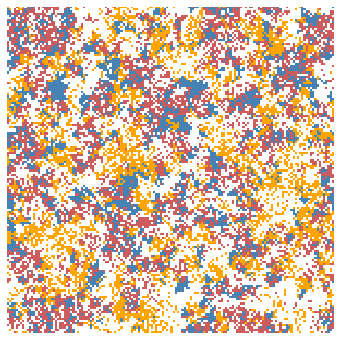

In [17]:
# set paramaters of simulation
num_row = 150
num_col = 150
num_agents = num_row*num_col
num_steps = num_agents*2000
beta01 = 0.8
beta02 = 0.5
beta21 = 0.5
beta12 = 0.8
v1 = 0.05
v2 = 0.1
prb = 0.95 # probability of susceptible birth
eps = 0 # considers movement

s_counts = []
i1_counts = []
i2_counts = []
time_steps = []

grid = set_grid(5000, 2250, 2250, num_agents)

# loop through certain number of times (Moore neighborhood); monte carlo step is considered when N loops are complete, where N = number of agents

for i in range(num_steps):
    agent_rules_moore(grid, beta01, beta02, beta12, beta21, v1, v2, prb, eps)
    if i % num_agents == 0:
        print("Time: ", i/num_agents)
        lattice = grid.reshape((num_row, num_col)).copy()
        cmap = colors.ListedColormap(['white','steelblue', 'orange', 'indianred'])
        plt.figure(figsize=(6,6))
        plt.axis('off')
        plt.imshow(lattice, cmap=cmap, animated=True)
        plt.show()
        display.clear_output(wait=True)
        #time.sleep(0.01)

        s_counts.append((grid == 1).sum())
        i1_counts.append((grid == 2).sum())
        i2_counts.append((grid == 3).sum())
        time_steps.append(i/num_agents)

lattice = grid.reshape((num_row, num_col))
cmap = colors.ListedColormap(['white','steelblue', 'orange', 'indianred'])
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(lattice, cmap=cmap, animated=True)
plt.show()
display.clear_output(wait=True)

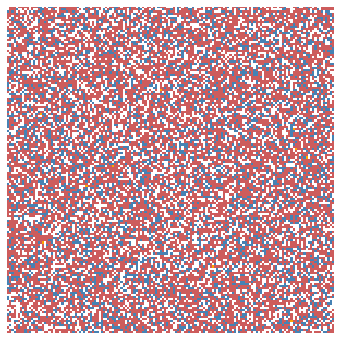

In [20]:
# set paramaters of simulation
num_row = 150
num_col = 150
num_agents = num_row*num_col
num_steps = num_agents*2000
beta01 = 0.8
beta02 = 0.5
beta21 = 0.5
beta12 = 0.8
v1 = 0.05
v2 = 0.1
prb = 0.95 # probability of susceptible birth
eps = 0 # considers movement

s_counts = []
i1_counts = []
i2_counts = []
time_steps = []

grid = set_grid(5000, 2250, 2250, num_agents)

# loop through certain number of times (Global neighborhood); monte carlo step is considered when N loops are complete, where N = number of agents

for i in range(num_steps):
    agent_rules_global(grid, beta01, beta02, beta12, beta21, v1, v2, prb, eps)
    if i % num_agents == 0:
        print("Time: ", i/num_agents)
        lattice = grid.reshape((num_row, num_col)).copy()
        cmap = colors.ListedColormap(['white','steelblue', 'orange', 'indianred'])
        plt.figure(figsize=(6,6))
        plt.axis('off')
        plt.imshow(lattice, cmap=cmap, animated=True)
        plt.show()
        display.clear_output(wait=True)
        #time.sleep(0.1)

        s_counts.append((grid == 1).sum())
        i1_counts.append((grid == 2).sum())
        i2_counts.append((grid == 3).sum())
        time_steps.append(i/num_agents)
        frames_0.append(lattice)

lattice = grid.reshape((num_row, num_col))
cmap = colors.ListedColormap(['white','steelblue', 'orange', 'indianred'])
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(lattice, cmap=cmap, animated=True)
plt.show()
display.clear_output(wait=True)

## AGM with Three Strains

### AGM Setup Functions

In [21]:
#Set grid, represented as 1d numpy array
@jit(nopython=True)
def set_grid(num_sus, num_s1, num_s2, num_s3, num_agents):
    if (num_sus+num_s1+num_s2+num_s3) <= num_agents and num_agents**.5 % 1 == 0:
        frac_sus = num_sus/num_agents
        frac_s1 = num_s1/num_agents
        frac_s2 = num_s2/num_agents
        frac_s3 = num_s3/num_agents
        frac_empty = 1 - frac_sus - frac_s1 - frac_s2 - frac_s3
        grid = np.random.choice(np.array([0,1,2,3,4]), num_agents, [frac_empty,frac_sus,frac_s1,frac_s2,frac_s3])
        return grid
    else:
        print('Error. Number of agents exceeds grid size.')

# function to find all neighbors of an agent
@jit(nopython=True)
def get_neighbors(index, grid):
    sideLength = int(np.sqrt(len(grid)))
    above = (index - sideLength) % len(grid)
    right = np.floor(index / sideLength)*sideLength + (index % sideLength + 1) % sideLength
    bottom = (index + sideLength) % len(grid)
    left = np.floor(index / sideLength)*sideLength + (index % sideLength - 1) % sideLength
        
    top_right = (right - sideLength) % len(grid)
    bottom_right = (right + sideLength) % len(grid)
    bottom_left = (left + sideLength) % len(grid)
    top_left = (left - sideLength) % len(grid)
    
    res = [above,right,bottom,left,top_right,bottom_right,bottom_left,top_left]
    res = np.array(res).T.astype(np.int64)
    rand_idx = np.random.randint(0, res.size)
    return res[rand_idx]


# rules associated with compartmental model; considers a moore neighborhood
@jit(nopython=True)
def agent_rules_moore(grid, beta01, beta02, beta03, beta12, beta21, beta23, beta32, beta13, beta31, v1, v2, v3, prb, eps):
    rand_agent_idx = np.random.randint(0, grid.size)
    agent_state = grid[rand_agent_idx]
    event_id = np.random.randint(1, 15)
    
    if event_id == 1:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < eps:
            grid[rand_agent_idx] = nbr_state
            grid[rand_nbr] = agent_state
    elif event_id == 2 and agent_state == 1:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < prb and nbr_state == 0:
            grid[rand_nbr] = 1
    elif event_id == 3 and agent_state == 2:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta01 and nbr_state == 1:
            grid[rand_nbr] = 2
    elif event_id == 4 and agent_state == 3:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta02 and nbr_state == 1:
            grid[rand_nbr] = 3
    elif event_id == 5 and agent_state == 4:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta03 and nbr_state == 1:
            grid[rand_nbr] = 4
    elif event_id == 6 and agent_state == 2:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta21 and nbr_state == 3:
            grid[rand_nbr] = 2
    elif event_id == 7 and agent_state == 3:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta12 and nbr_state == 2:
            grid[rand_nbr] = 3
    elif event_id == 8 and agent_state == 3:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta32 and nbr_state == 4:
            grid[rand_nbr] = 3
    elif event_id == 9 and agent_state == 4:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta23 and nbr_state == 3:
            grid[rand_nbr] = 4
    elif event_id == 10 and agent_state == 2:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta31 and nbr_state == 4:
            grid[rand_nbr] = 2
    elif event_id == 11 and agent_state == 4:
        rand_nbr = get_neighbors(rand_agent_idx, grid)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta13 and nbr_state == 2:
            grid[rand_nbr] = 4
    elif event_id == 12 and agent_state == 2:
        if np.random.uniform(0,1) < v1:
            grid[rand_agent_idx] = 0
    elif event_id == 13 and agent_state == 3:
        if np.random.uniform(0,1) < v2:
            grid[rand_agent_idx] = 0
    elif event_id == 14 and agent_state == 4:
        if np.random.uniform(0,1) < v3:
            grid[rand_agent_idx] = 0
    
# rules associated with compartmental model; considers a global neighborhood
@jit(nopython=True)
def agent_rules_global(grid, beta01, beta02, beta03, beta12, beta21, beta23, beta32, beta13, beta31, v1, v2, v3, prb, eps):
    rand_agent_idx = np.random.randint(0, grid.size)
    agent_state = grid[rand_agent_idx]
    event_id = np.random.randint(1, 15)
    
    if event_id == 1:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < eps:
            grid[rand_agent_idx] = nbr_state
            grid[rand_nbr] = agent_state
    elif event_id == 2 and agent_state == 1:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < prb and nbr_state == 0:
            grid[rand_nbr] = 1
    elif event_id == 3 and agent_state == 2:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta01 and nbr_state == 1:
            grid[rand_nbr] = 2
    elif event_id == 4 and agent_state == 3:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta02 and nbr_state == 1:
            grid[rand_nbr] = 3
    elif event_id == 5 and agent_state == 4:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta03 and nbr_state == 1:
            grid[rand_nbr] = 4
    elif event_id == 6 and agent_state == 2:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta21 and nbr_state == 3:
            grid[rand_nbr] = 2
    elif event_id == 7 and agent_state == 3:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta12 and nbr_state == 2:
            grid[rand_nbr] = 3
    elif event_id == 8 and agent_state == 3:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta32 and nbr_state == 4:
            grid[rand_nbr] = 3
    elif event_id == 9 and agent_state == 4:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta23 and nbr_state == 3:
            grid[rand_nbr] = 4
    elif event_id == 10 and agent_state == 2:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta31 and nbr_state == 4:
            grid[rand_nbr] = 2
    elif event_id == 11 and agent_state == 4:
        rand_nbr = np.random.randint(0, grid.size)
        nbr_state = grid[rand_nbr]
        if np.random.uniform(0,1) < beta13 and nbr_state == 2:
            grid[rand_nbr] = 4
    elif event_id == 12 and agent_state == 2:
        if np.random.uniform(0,1) < v1:
            grid[rand_agent_idx] = 0
    elif event_id == 13 and agent_state == 3:
        if np.random.uniform(0,1) < v2:
            grid[rand_agent_idx] = 0
    elif event_id == 14 and agent_state == 4:
        if np.random.uniform(0,1) < v3:
            grid[rand_agent_idx] = 0

### Moore Neighborhood

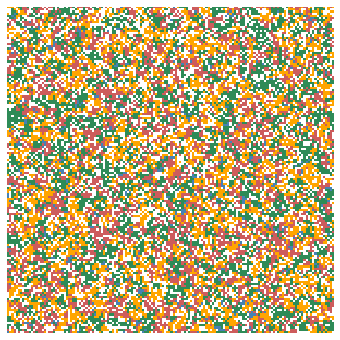

In [39]:
# set paramaters of simulation
num_row = 150
num_col = 150
num_agents = num_row*num_col
num_steps = num_agents*5000
beta01 = 0.8 
beta02 = 0.5 
beta21 = 0.8
beta12 = 0.5
beta23 = 0.5
beta32 = 0.8
beta13 = 0.8
beta31 = 0.5
v1 = 0.05
v2 = 0.04
v3 = 0.03
prb = 0.95
eps = 0.00

s_counts = []
i1_counts = []
i2_counts = []
i3_counts = []
time_steps = []
frames = []

grid = set_grid(5000, 2000, 2000, 2000, num_agents)

# loop through certain number of times (Moore neighborhood); monte carlo step is considered when N loops are complete, where N = number of agents

for i in range(num_steps):
    agent_rules_moore(grid, beta01, beta02, beta03, beta12, beta21, beta23, beta32, beta13, beta31, v1, v2, v3, prb, eps)
    if i % num_agents == 0:
        print("Time: ", i/num_agents)
        lattice = grid.reshape((num_row, num_col))
        cmap = colors.ListedColormap(['white','steelblue', 'orange', 'indianred', 'seagreen'])
        plt.figure(figsize=(6,6))
        plt.axis('off')
        plt.imshow(lattice, cmap=cmap, animated=True)
        plt.show()
        display.clear_output(wait=True)
        #time.sleep(0.2)

        s_counts.append((grid == 1).sum())
        i1_counts.append((grid == 2).sum())
        i2_counts.append((grid == 3).sum())
        i3_counts.append((grid == 4).sum())
        time_steps.append(i/num_agents)

lattice = grid.reshape((num_row, num_col))
cmap = colors.ListedColormap(['white','steelblue', 'orange', 'indianred', 'seagreen'])
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(lattice, cmap=cmap, animated=True)
plt.show()
display.clear_output(wait=True)
#time.sleep(0.2)

### Global Neighborhood

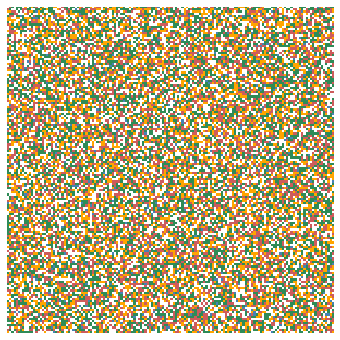

In [42]:
# set paramaters of simulation
num_row = 150
num_col = 150
num_agents = num_row*num_col
num_steps = num_agents*5000
beta01 = 0.8 
beta02 = 0.5 
beta21 = 0.8
beta12 = 0.5
beta23 = 0.5
beta32 = 0.8
beta13 = 0.8
beta31 = 0.5
v1 = 0.05
v2 = 0.04
v3 = 0.03
prb = 0.95
eps = 0.00

s_counts = []
i1_counts = []
i2_counts = []
i3_counts = []
time_steps = []
frames = []

grid = set_grid(5000, 2000, 2000, 2000, num_agents)

# loop through certain number of times (Moore neighborhood); monte carlo step is considered when N loops are complete, where N = number of agents

for i in range(num_steps):
    agent_rules_global(grid, beta01, beta02, beta03, beta12, beta21, beta23, beta32, beta13, beta31, v1, v2, v3, prb, eps)
    if i % num_agents == 0:
        print("Time: ", i/num_agents)
        lattice = grid.reshape((num_row, num_col))
        cmap = colors.ListedColormap(['white','steelblue', 'orange', 'indianred', 'seagreen'])
        plt.figure(figsize=(6,6))
        plt.axis('off')
        plt.imshow(lattice, cmap=cmap, animated=True)
        plt.show()
        display.clear_output(wait=True)
        #time.sleep(0.2)

        s_counts.append((grid == 1).sum())
        i1_counts.append((grid == 2).sum())
        i2_counts.append((grid == 3).sum())
        i3_counts.append((grid == 4).sum())
        time_steps.append(i/num_agents)

lattice = grid.reshape((num_row, num_col))
cmap = colors.ListedColormap(['white','steelblue', 'orange', 'indianred', 'seagreen'])
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(lattice, cmap=cmap, animated=True)
plt.show()
display.clear_output(wait=True)
#time.sleep(0.2)